# Certis Quickstart

## This notebook is a demonstration of:
- supported order types (list all of them)
- defining basic strategy (Simple Moving Average - SMA)
- downloading financial timeseries from yahoo finance
- input data format
- initialization of MarketInfo object (parameters that characterize given exchange, e.g. transaction fees)
- initialization and run of engine (combined

In [1]:
# Add parent directory to path
import sys; sys.path.insert(0, '..')

In [2]:
import certis
from typing import *

# Supported Order Types
- LIMIT
- MARKET
- STOP_MARKET
- STOP_LOSS_MARKET
- TAKE_PROFIT_MARKET

<a href="https://www.investor.gov/introduction-investing/investing-basics/how-stock-markets-work/types-orders"> order type docs for beginners

In [3]:
certis.OrderType.ORDERS

['MARKET', 'LIMIT', 'STOP_MARKET', 'STOP_LOSS_MARKET', 'TAKE_PROFIT_MARKET']

# Supportd Order Sides
LONG: betting for upside
SHORT: betting for downside

In [4]:
print("certis.OrderSide.LONG:", certis.OrderSide.LONG)
print("certis.OrderSide.SHORT:", certis.OrderSide.SHORT)

certis.OrderSide.LONG: 1
certis.OrderSide.SHORT: -1


In [5]:
#from pprint import pprint

In [6]:
#pprint({"margin": 10000, "portfolio_value": 10000.0, "position": {"size": 0, "side": 0, "avg_price": 0, "unrealized_pnl": 0.0}, "has_position": "False", "timestamp": 1579076100000000000}, indent=False)

# Writing Trading Strategy With Certis
- function certis.Startegy.execute() -> executes order with given data and account info
- function certis.Strategy.calculate() -> calculates indicators, etc with given raw data

# MA Cross Strategy
- In this Tutorial, We will write a simple strategy called "MA Cross Strategy"
- BUY WHEN CLOSE > MA(CLOSE, 5)
- SELL WHEN CLOSE < MA(CLOSE, 5)

In [7]:
class MyFirstStrategy(certis.Strategy):
    def __init__(self, config):
        # config: Dict[str, Any]: config for this strategy
        # name: str: name for this strategy
        super().__init__(config, "MyFirstStrategy")
        self.ma_period = config["MA_PERIOD"]

    def calculate(self, data):
        # data: pd.DataFrame contains [open, high, low, close, volume, timestamp]
        # calculations here
        data["MA"] = data["close"].rolling(self.ma_period).mean()
        return data

    def execute(self, state_dict) -> List[certis.core.Action]:
        actions = []

        """
        state_dict example:
            {
                'has_position': 0,
                 'margin': 10000,
                 'portfolio_value': 10000.0,
                 'position': {
                     'avg_price': 0,
                     'side': 0,
                     'size': 0,
                     'unrealized_pnl': 0.0
                 },
                 'timestamp': 1579076100000000000
            }
        """

        has_position = state_dict["account_info"]["has_position"]
        portfolio_value = state_dict["account_info"]["portfolio_value"]
        position_size = state_dict["account_info"]["position"]["size"]
        data = state_dict["data"]

        if not state_dict["account_info"]["has_position"]:
            if data["close"] > data["MA"]: # if above ma
                order = certis.Order(
                    order_type=certis.OrderType.MARKET,
                    order_quantity=portfolio_value / data["close"], # full bet!,
                    order_side=certis.OrderSide.LONG,
                    order_price=None, # MARKET ORDER
                    reduce_only=False
                )
                actions.append(order)

        else:
            if data["close"] < data["MA"]:
                order = certis.Order(
                    order_type=certis.OrderType.MARKET,
                    order_quantity=position_size, # full bet!,
                    order_side=certis.OrderSide.SHORT,
                    order_price=None, # MARKET ORDER
                    reduce_only=True
                )
                actions.append(order)

        return actions


# Market Info Object
- essential market info for the backtesting
- maker fee: fee for limit orders
- taker fee: fee for market orders
- slippage: slippage applied for market orders
- tick_size: tick size
- minimum_order_size: minimum order size

In [8]:
market_info = certis.MarketInfo(
    maker_fee=0.001,
    taker_fee=0.001,
    slippage=0.001,
    minimum_order_size=0.001,
    tick_size=0.01
)

# Load data
Certis Supports pandas DataFrame with `[timestamp, open, high, low, close, volume]` with datetime indexes

In [27]:
from yfinance import Ticker

data = Ticker("BTC-USD").history(period="max")
data = data[data.columns[:5]]
data.columns = ["open", "high", "low", "close", "volume"]
data["timestamp"] = data.index.astype(int)
fin_data = data.copy()

# Initialize Engine
### to initialize certis backtesting engine, you need following components:
- data: pandas DataFrame
- initial margin: float
- market info: MarketInfo Object
- strategy: Strategy Class
- strategy config: strategy config

In [49]:
MA_WINDOW = 7
initial_margin = 100000
strategy_config = {"MA_PERIOD": MA_WINDOW}

engine = certis.Engine(
    data,
    initial_margin,
    market_info,
    MyFirstStrategy,
    strategy_config
)

In [50]:
engine.run()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2831/2831 [00:00<00:00, 60010.69it/s]


# Analyzing Results
The data for analysis can be obtained from the logger.
- `engine.logger.account_infos`:  account info for timestamp-by-timestamp
- `engine.logger.transactions`:   order fill (transactions)
- `engine.logger.unfilled_order`: unfilled order for timestamp-by-timestamp

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
account_info_df = pd.DataFrame(engine.logger.account_infos)
account_info_df.index = pd.to_datetime(account_info_df["timestamp"])

## Account info from the logger in form of Data Frame

In [53]:
account_info_df.head(3)

,margin,portfolio_value,position,has_position,timestamp
timestamp,,,,,
2014-09-24,100000.000000,100000.000000,"{'size': 0, 'side': 0, 'avg_price': 0, 'unreal...",0,1.411517e+18
2014-09-25,99899.911084,96922.573678,"{'size': 229.467, 'side': 1.0, 'avg_price': 43...",1,1.411603e+18
2014-09-26,99899.911084,94253.647258,"{'size': 229.467, 'side': 1.0, 'avg_price': 43...",1,1.411690e+18


In [54]:
account_info_df.iloc[5].position

{'size': 0, 'side': 0, 'avg_price': 0, 'unrealized_pnl': 0.0}

## Plot portfolio value
On the plot below there is:
- portfolio value in given point of time relative to the initial portfolio value
- BTC value in given point of time relative to the initial BTC value

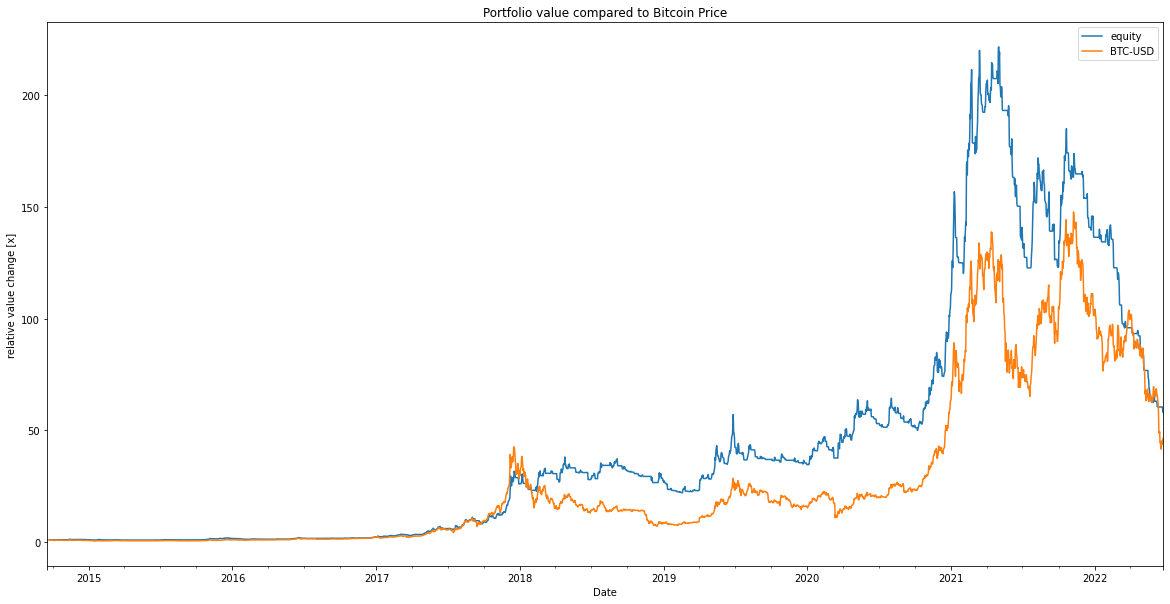

In [55]:
(account_info_df["portfolio_value"] / initial_margin).plot(label="equity", figsize=(20, 10))
ax = (data["close"] / data["close"][0]).plot(label="BTC-USD")
plt.legend()
ax.set_title('Portfolio value compared to Bitcoin Price');
ax.set_ylabel('relative value change [x]');

In [56]:
engine.logger.transactions[:2]

[{'timestamp': 1411516800000000000,
  'realized': {'pnl': 0, 'fee': 100.08891606},
  'order': {'price': 436.18,
   'quantity': 229.467,
   'side': 1,
   'type': 'MARKET'}},
 {'timestamp': 1411776000000000000,
  'realized': {'pnl': -7579.295009999994, 'fee': 92.50962105000002},
  'order': {'price': 403.15000000000003,
   'quantity': 229.467,
   'side': -1,
   'type': 'MARKET'}}]

In [57]:
transactions_df = pd.DataFrame(engine.logger.transactions)
transactions_df.index = pd.to_datetime(transactions_df["timestamp"])
transactions_df.sample(5)

,timestamp,realized,order
timestamp,,,
2020-07-02,1593648000000000000,"{'pnl': 0, 'fee': 5309.45191941}","{'price': 9240.37, 'quantity': 574.593, 'side'..."
2020-06-04,1591228800000000000,"{'pnl': 0, 'fee': 5919.6222684800005}","{'price': 9665.51, 'quantity': 612.448, 'side'..."
2019-04-26,1556236800000000000,"{'pnl': -19679.541799999864, 'fee': 2823.42299...","{'price': 5205.09, 'quantity': 542.43500000000..."
2019-12-10,1575936000000000000,"{'pnl': -32903.858879999876, 'fee': 3561.08132...","{'price': 7389.7300000000005, 'quantity': 481...."
2017-10-27,1509062400000000000,"{'pnl': 0, 'fee': 1082.88584495}","{'price': 5905.63, 'quantity': 183.365, 'side'..."


In [58]:
realized = pd.DataFrame(transactions_df.realized.to_dict()).T
order = pd.DataFrame(transactions_df.order.to_dict()).T
re_ord=realized.join(order)
tr = re_ord.join(transactions_df).drop(['realized','order'], axis=1)
tr

,pnl,fee,price,quantity,side,type,timestamp
2014-09-24,0.00000,100.088916,436.18,229.467,1,MARKET,1411516800000000000
2014-09-27,-7579.29501,92.509621,403.15,229.467,-1,MARKET,1411776000000000000
2014-10-09,0.00000,92.269620,353.1,261.313,1,MARKET,1412812800000000000
2014-10-18,7967.40288,100.236670,383.59,261.312,-1,MARKET,1413590400000000000
2014-10-19,0.00000,100.053446,391.64,255.473,1,MARKET,1413676800000000000
...,...,...,...,...,...,...,...
2022-06-09,-244601.49270,6061.582639,30185.06,200.814,-1,MARKET,1654732800000000000
2022-06-10,-1.32290,0.030080,30080.21,0.001,-1,MARKET,1654819200000000000
2022-06-22,0.00000,6051.368470,20740.13,291.771,1,MARKET,1655856000000000000
2022-06-23,-225687.78621,5825.680684,19966.62,291.771,-1,MARKET,1655942400000000000


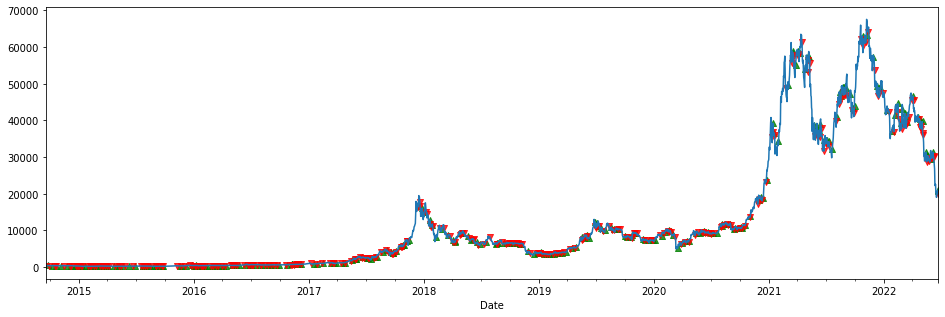

In [59]:
f, axs = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(16, 5),
)
buys = tr[tr.side==1]
sells = tr[tr.side==-1]
price = data['close']
sma = data.rolling(window=MA_WINDOW).mean().dropna()
sma = pd.DataFrame(sma['close'])
price.plot(ax=axs)
axs.scatter(buys.index,buys.price, alpha=0.8, label="Buy", marker="^", color="green")
axs.scatter(sells.index,sells.price, alpha=0.8, label="Sell", marker="v", color="red")


In [60]:
sma

,close
Date,
2014-09-29,403.880423
2014-09-30,396.902283
2014-10-01,391.246569
2014-10-02,386.031996
2014-10-03,379.615853
...,...
2022-06-20,20829.030971
2022-06-21,20615.288783
2022-06-22,20245.887277


In [62]:
# Plotting

import plotly.io as pio
import plotly.graph_objects as go

# pio.templates.default = "plotly_dark"

fig = go.Figure()

data = fin_data.copy()
# price
k=0.01
fig.add_trace(go.Scatter(x=data.index,
                         y=data['close'],
                         name='Close',
                         line_color='#222222'
                        ))

# # SMA
fig.add_trace(go.Scatter(x=sma.index,
                         y=sma['close'],
                         name='SMA',
                         line_color='#FECB52'
                        ))



# buy signals
fig.add_trace(go.Scatter(x=buys.index,
                         y=(1-k) * buys.price,
                         name='Buys',
                         mode='markers',
                         marker=dict(
                             color='#00CC96',
                             size=10,
                             symbol='triangle-up'
                             )
                         ))
# sell signals
fig.add_trace(go.Scatter(x=sells.index,
                         y=(1+k)*sells.price,
                         name='Sells',
                         mode='markers',
                         marker=dict(
                             color='#EF553B',
                             size=10,
                             symbol='triangle-down'
                             )
                         ))

fig.update_layout(
    autosize=False,
    width=960,
    height=700,)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
       autorange = True,
       fixedrange= False
   )
)


# fig.show()
figu = go.FigureWidget(data=fig, layout=layout)

def zoom(layout, xrange):
    in_view = data.loc[figu.layout.xaxis.range[0]:figu.layout.xaxis.range[1]]
    figu.layout.yaxis.range = [in_view.high.min() - 10, in_view.high.max() + 10]

figu.layout.on_change(zoom, 'xaxis.range')
figu

FigureWidget({
    'data': [{'line': {'color': '#222222'},
              'name': 'Close',
              'type'…

In [22]:
buys

,pnl,fee,price,quantity,side,type,timestamp
2014-10-15,0.0,100.119567,401.35,249.457,1,MARKET,1413331200000000000
2014-11-10,0.0,88.895930,362.62,245.149,1,MARKET,1415577600000000000
2014-11-24,0.0,87.564133,367.31,238.393,1,MARKET,1416787200000000000
2015-01-27,0.0,87.860374,273.44,321.315,1,MARKET,1422316800000000000
2015-02-14,0.0,74.855450,235.76,317.507,1,MARKET,1423872000000000000
...,...,...,...,...,...,...,...
2022-03-10,0.0,9008.491072,42016.04,214.406,1,MARKET,1646870400000000000
2022-03-17,0.0,8430.939674,41181.98,204.724,1,MARKET,1647475200000000000
2022-05-31,0.0,8630.563288,31755.58,271.781,1,MARKET,1653955200000000000
2022-06-03,0.0,8073.075059,30498.27,264.706,1,MARKET,1654214400000000000


In [23]:
fin_data = data.copy()

In [24]:
import plotly.graph_objs as go

from datetime import datetime
import pandas_datareader.data as web

df = fin_data.copy()

# Make sure dates are in ascending order
# We need this for slicing in the callback below
df.sort_index(ascending=True, inplace=True)

trace = go.Scatter(x=list(df.index),
                   y=list(df.high))

data = [trace]
layout = dict(
    title='Time series with range slider and selectors',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = go.FigureWidget(data=data, layout=layout)
fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '67d73ad6-145e-4e8f-8927-d1a1fe24f49e',
 …

In [25]:
def zoom(layout, xrange):
    in_view = df.loc[fig.layout.xaxis.range[0]:fig.layout.xaxis.range[1]]
    fig.layout.yaxis.range = [in_view.high.min() - 10, in_view.high.max() + 10]

fig.layout.on_change(zoom, 'xaxis.range')